# AIPI 590 - XAI | Assignment #05
### Explainable Deep Learning
### Diya Mirji

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_explainable_deeplearning.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_explainable_deeplearning.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data
!rm -r ./Duke-AI-XAI

# Clone GitHub files to colab workspace
repo_name = "Duke-XAI" # Change to your repo name
git_path = 'https://github.com/dvm14/Duke-XAI.git' #Change to your path
!git clone "{git_path}"

# Change working directory to location of notebook
%cd "{repo_name}"
%ls

rm: cannot remove './Duke-AI-XAI': No such file or directory
Cloning into 'Duke-XAI'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 14), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 1.76 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Duke-XAI
diya_assignment2.ipynb               machine_learning_court.ipynb
diya_explainable_2.ipynb             README.md
diya_explainable_deeplearning.ipynb  Telco-Customer-Churn.csv
lime_exp2.png                        wine_quality_merged.csv


In [2]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pygam
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=bd60d70f18eb0770358ac3149ad886fcffad069f07b04348d65aec64cb24eb32
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [22]:
# Data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision.models import resnet50
import torch.optim as optim
import torch.nn as nn
import torch

# XAI
import seaborn as sns
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### Kaggle Dataset Citation
Obuli Sai Naren. (2021). Retinal OCT Image Classification - C8 [Data set]. Kaggle.
https://doi.org/10.34740/KAGGLE/DSV/2736749

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/retinal-oct-c8")

print("Path to dataset files:", path)

100%|██████████| 1.42G/1.42G [00:18<00:00, 80.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/obulisainaren/retinal-oct-c8/versions/3


In [5]:
data_path = "/root/.cache/kagglehub/datasets/obulisainaren/retinal-oct-c8/versions/3/RetinalOCT_Dataset/RetinalOCT_Dataset"
%ls {data_path}

train_path = os.path.join(data_path, "train")
val_path = os.path.join(data_path, "val")
test_path = os.path.join(data_path, "test")
%ls {train_path}

test/  train/  val/
AMD/  CNV/  CSR/  DME/  DR/  DRUSEN/  MH/  NORMAL/


### Citation for Code on Image Processing and Modeling
https://www.kaggle.com/code/ashikshahriar/retinal-disease-classification

In [6]:
def create_dataframe(path):
  data = []
  for label in os.listdir(path):
    if label in ['NORMAL', 'AMD', 'CNV', 'CSR']:
      label_path = os.path.join(path, label)
      if os.path.isdir(label_path):
        for image in os.listdir(label_path):
          image_path = os.path.join(label_path, image)
          data.append([image_path, label])
  return pd.DataFrame(data, columns=["image_path", "label"])

In [7]:
train_data = create_dataframe(train_path)
val_data = create_dataframe(val_path)
test_data = create_dataframe(test_path)

In [8]:
train_data.head()

,image_path,label
0,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
1,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
2,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
3,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
4,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV


In [9]:
val_data.head()

,image_path,label
0,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
1,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
2,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
3,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
4,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV


In [10]:
test_data.head()

,image_path,label
0,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
1,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
2,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
3,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV
4,/root/.cache/kagglehub/datasets/obulisainaren/...,CNV


In [11]:
print(train_data['label'].value_counts())
print(val_data['label'].value_counts())
print(test_data['label'].value_counts())

label
CNV       2300
NORMAL    2300
AMD       2300
CSR       2300
Name: count, dtype: int64
label
CNV       350
NORMAL    350
AMD       350
CSR       350
Name: count, dtype: int64
label
CNV       350
NORMAL    350
AMD       350
CSR       350
Name: count, dtype: int64


In [12]:
img_height, img_width = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical',
    shuffle=False
)

Found 9200 validated image filenames belonging to 4 classes.
Found 1400 validated image filenames belonging to 4 classes.
Found 1400 validated image filenames belonging to 4 classes.


Code block below generated with Claude Sonnet 4.5 10/3 at 1:30am.

In [23]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Code block below generated with Claude Sonnet 4.5 10/4 at 10:40am.

Processed 10/44 batches
Processed 20/44 batches
Processed 30/44 batches
Processed 40/44 batches

Validation Accuracy: 25.43%

Classification Report:
              precision    recall  f1-score   support

         AMD       0.46      0.02      0.03       350
         CNV       0.30      0.66      0.41       350
         CSR       0.67      0.03      0.05       350
      NORMAL       0.18      0.31      0.23       350

    accuracy                           0.25      1400
   macro avg       0.40      0.25      0.18      1400
weighted avg       0.40      0.25      0.18      1400



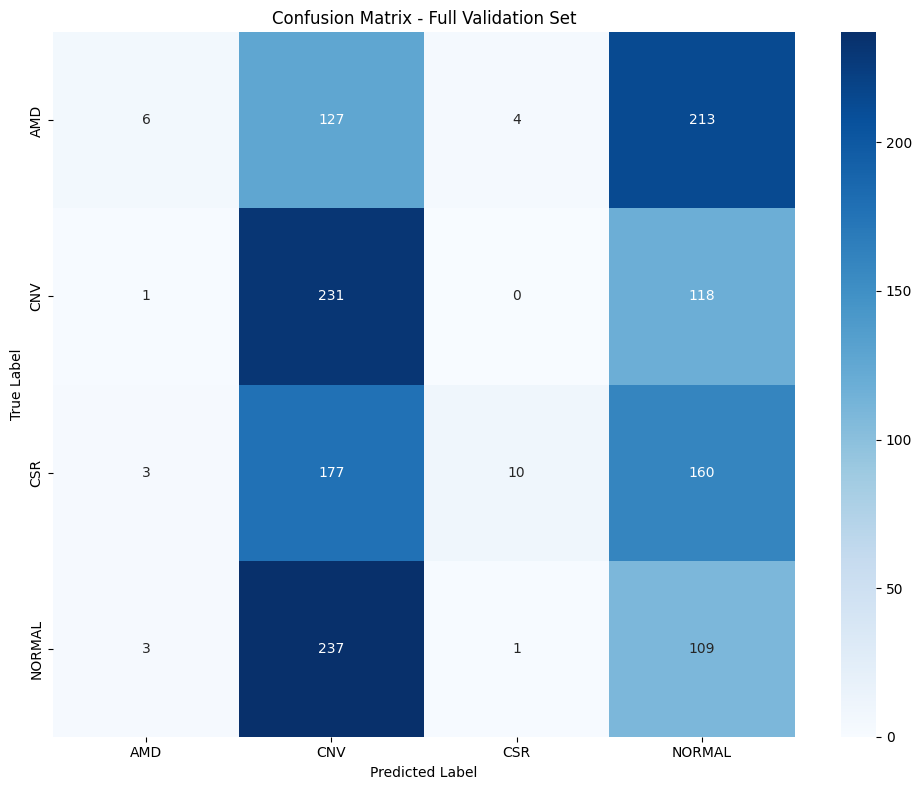

In [19]:
model.eval()
all_predictions = []
all_true_labels = []

val_generator.reset()
steps = len(val_generator)

class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

with torch.no_grad():
    for step in range(steps):
        # Get batch from generator
        batch_images, batch_labels = val_generator[step]

        # Convert numpy array to torch tensor
        batch_images_tensor = torch.from_numpy(batch_images).float()

        # Permute from (batch, height, width, channels) to (batch, channels, height, width)
        batch_images_tensor = batch_images_tensor.permute(0, 3, 1, 2).to(device)

        # Get predictions
        outputs = model(batch_images_tensor)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        # Handle labels (might be one-hot encoded or class indices)
        if len(batch_labels.shape) > 1 and batch_labels.shape[1] > 1:
            true_labels = np.argmax(batch_labels, axis=1)  # One-hot to indices
        else:
            true_labels = batch_labels.flatten()  # Already indices

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

        if (step + 1) % 10 == 0:
            print(f"Processed {step + 1}/{steps} batches")

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Full Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

As shown above through the confusion matrix, the pretrained Resnet50 model is not very good at classifying the images with a 25.43% accuracy, it is mostly predicting all retinal images as CNV or Normal.

### Citation for the next cell block:

```
@misc{jacobgilpytorchcam,
  title={PyTorch library for CAM methods},
  author={Jacob Gildenblat and contributors},
  year={2021},
  publisher={GitHub},
  howpublished={\url{https://github.com/jacobgil/pytorch-grad-cam}},
}
```

Integrated with the help of Claude Sonnet 4.5 on 10/3 at 12:55am


Output: tensor([[0.5583, 0.0511, 0.5166, 0.1302]])
Predicted class: 0


100%|██████████| 128/128 [03:49<00:00,  1.80s/it]


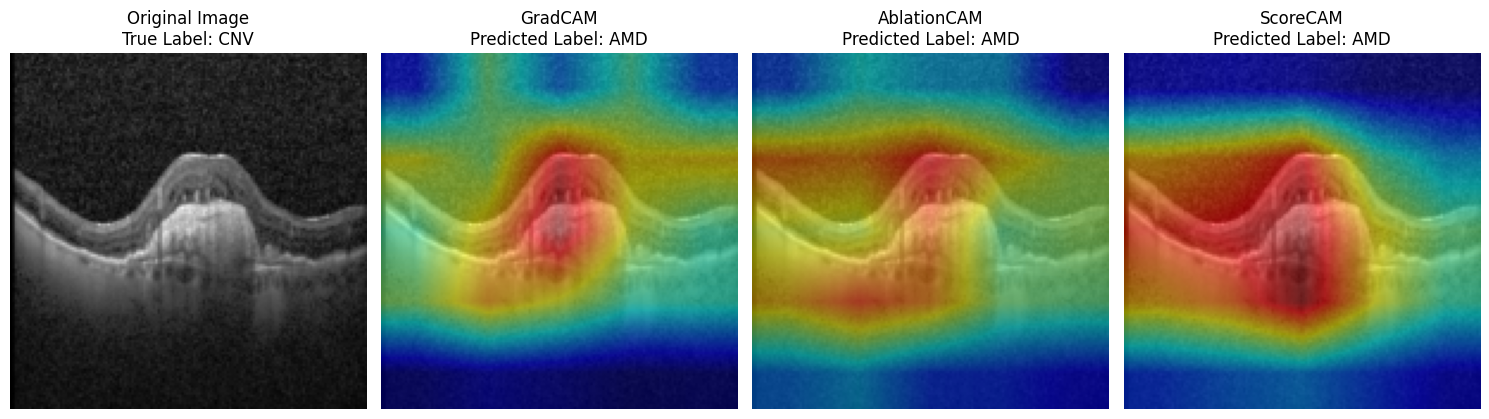

Output: tensor([[ 0.4162, -0.0971,  0.1541,  0.1420]])
Predicted class: 0


100%|██████████| 128/128 [03:55<00:00,  1.84s/it]


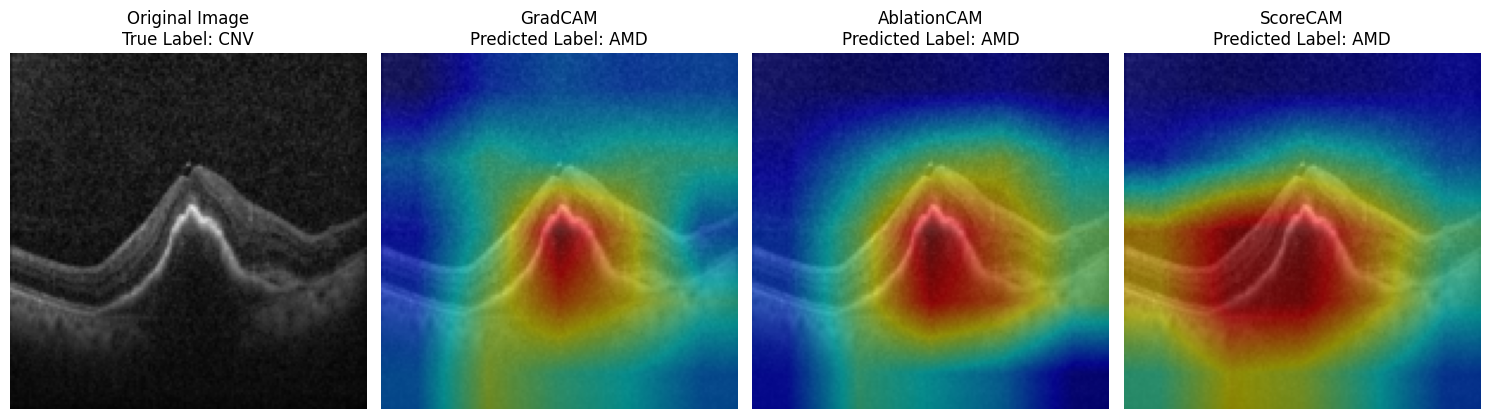

Output: tensor([[ 0.5088, -0.0416,  0.1488,  0.4950]])
Predicted class: 0


100%|██████████| 128/128 [03:53<00:00,  1.83s/it]


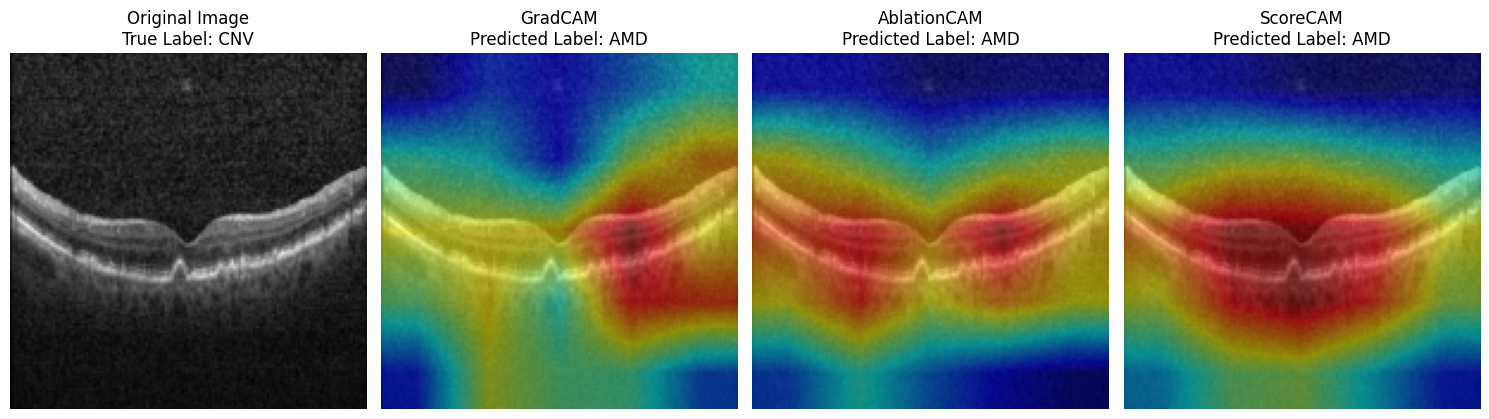

Output: tensor([[ 0.4713, -0.1149,  0.1281,  0.2321]])
Predicted class: 0


100%|██████████| 128/128 [03:42<00:00,  1.74s/it]


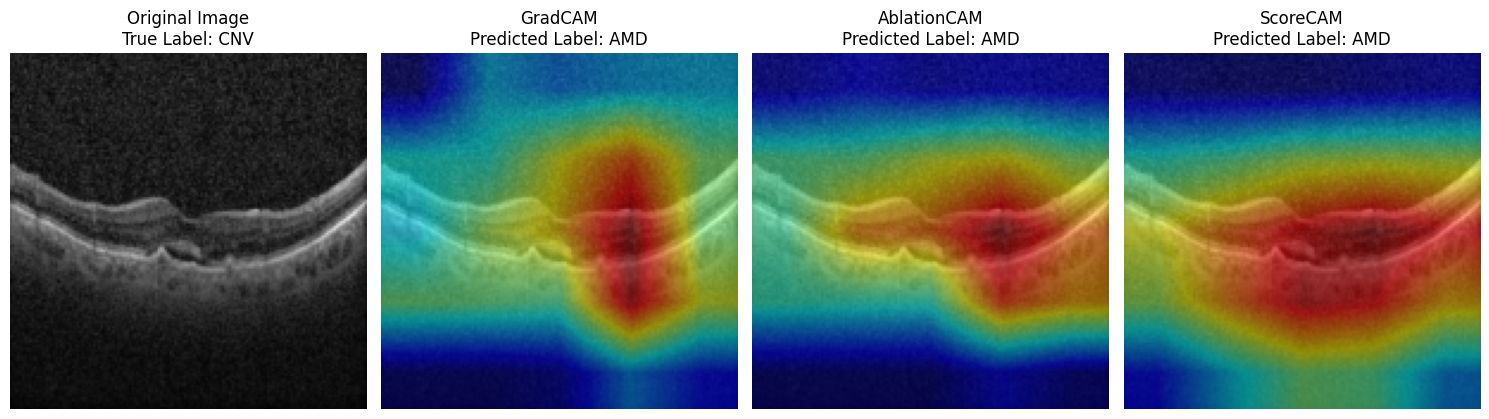

Output: tensor([[0.0648, 0.1858, 0.4205, 0.2359]])
Predicted class: 2


100%|██████████| 128/128 [03:38<00:00,  1.71s/it]


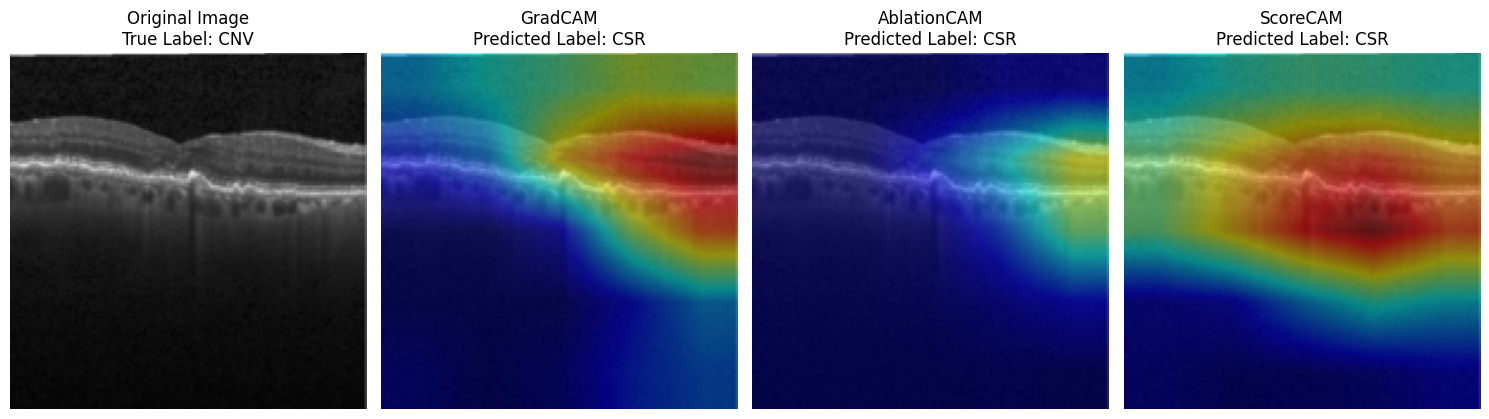

In [21]:
target_layers = [model.layer4[-1]] # Assuming layer4[-1] is the last convolutional layer

# Get image paths and labels from the validation data
image_paths = val_data['image_path'].tolist()
labels = val_data['label'].tolist()

# Get the class indices from the generator for mapping
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Select the first 5 images and labels
selected_image_paths = image_paths[:5]
selected_labels = labels[:5]

# Prepare the input tensors and true labels
selected_images_tensor = []
true_labels_index = []

# Define the same transformations as used in ImageDataGenerator (rescaling and resizing)
preprocess = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    # No normalization here as it's done by ImageDataGenerator's rescale=1./255
])

for i in range(len(selected_image_paths)):
    img_path = selected_image_paths[i]
    label = selected_labels[i]

    # Load the image
    img = Image.open(img_path).convert('RGB')

    # Apply preprocessing and add batch dimension, move to device
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    selected_images_tensor.append(input_tensor)

    # Get the true label index
    true_label_index = class_indices[label]
    true_labels_index.append(true_label_index)

# Now loop through the selected images and generate CAMs
for i in range(len(selected_images_tensor)):
    input_tensor = selected_images_tensor[i]
    true_label = true_labels_index[i]

    # Convert tensor back to numpy for visualization (and remove batch dim)
    rgb_img = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    # Don't convert to uint8!

    # Construct the CAM objects
    cam = GradCAM(model=model, target_layers=target_layers)
    ab_cam = AblationCAM(model=model, target_layers=target_layers)
    sc_cam = ScoreCAM(model=model, target_layers=target_layers)

    # Get the predicted class
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output).item()
    print(f"Output: {output}")
    print(f"Predicted class: {predicted_class}")

    # Create proper targets
    targets = [ClassifierOutputTarget(predicted_class)]

    # Generate CAMs
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    ab_grayscale_cam = ab_cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)
    sc_grayscale_cam = sc_cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

    # Extract the first image from batch
    grayscale_cam = grayscale_cam[0, :]
    ab_grayscale_cam = ab_grayscale_cam[0, :]
    sc_grayscale_cam = sc_grayscale_cam[0, :]

    # Visualize the CAMs (rgb_img is already in [0,1] range as float)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    ab_visualization = show_cam_on_image(rgb_img, ab_grayscale_cam, use_rgb=True)
    sc_visualization = show_cam_on_image(rgb_img, sc_grayscale_cam, use_rgb=True)

    # Get the class names from the generator's class indices
    true_label_name = idx_to_class[true_label]
    predicted_label_name = idx_to_class[predicted_class]

    # Display the original image and the CAM visualizations
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original Image\nTrue Label: {true_label_name}")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(visualization)
    plt.title(f"GradCAM\nPredicted Label: {predicted_label_name}")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(ab_visualization)
    plt.title(f"AblationCAM\nPredicted Label: {predicted_label_name}")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(sc_visualization)
    plt.title(f"ScoreCAM\nPredicted Label: {predicted_label_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Interpretation/Evaluation of GradCAM

All the 5 selected images' true label are CNV (Choroidal neovascularization). Signs of CNV are displayed by the neovascular membrane (white arrowheads) and associated subretinal fluid (arrows) as shown by the most left image below.
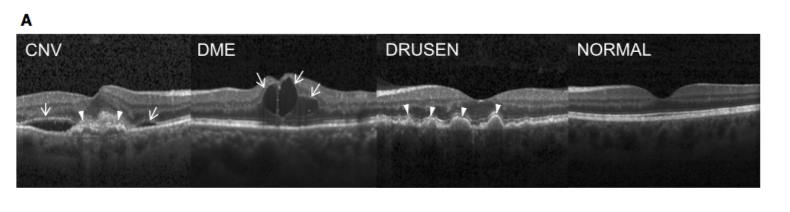

GradCAM is supposed to visualize what the model is looking at when making a prediction. So it highlights what parts of the image have high importance.

The red regions show the parts of the image that has high importance, the yellow/green regions show the parts of the image that have moderate importance, and the blue regions show the parts of the image that have low importance.

Since the model gave the wrong prediction for all 5 of these images, we can see what the model was looking at instead that gave the incorrect classification.

It is not very clear to determine what specific parts of the image the model is focusing on, but if the model was giving correct predictions I would expect the GradCAM visualizations to show red on the specific small black pockets of subretinal fluid under the neovascular membrane. However the current model has too large of a area of high importance regions, so it's not able to notice the smaller signs of the diseases.

In addition to GradCAM, I've used AblationCAM and ScoreCAM.

GradCAM weighs the 2D activations by the average gradient. THe AblationCAM zeros out activations and measures how the output drops, so it masks out different regions of the image and sees how the prediction changes. ScoreCAM pertubs the image by the scaled activations and measures how the output drops, so it only shows certain regions of the image and sees how the prediction changes.

In this modeling scenario, it seems like ScoreCAM gives a more broad area of high importance than GradCAM and AblationCAM. AbltaionCAM gives a mostly more precise high importance region than the others. And GradCAM gives a area size somewhere in between the AblationCAM and ScoreCAM.

In the first image, GradCAM gives a red region that is in the middle that does somewhat highlight the pocket of fluid under the membrane. But, AblationCAM seems kind of lost in what areas it thinks is important and Score CAM has too large of a high importance region to notice any smaller particularities.

In the second image, the high importance region increase from GradCAM to AblationCAM then to ScoreCAM. However, I think the important region is on the right middle area where it looks like there are small pockets of the fluid.

In the third image, I think the AblationCAM shows the best importance region where the pockets of fluid could be and they are more precise. The GradCAM misses the region and ScoreCAM is too large to find any pockets.

In the fourth image, the results are similar to the third image but I think GradCAM does a good job actually highlighting the general area of importance.

In the fifth image, all three miss where the pockets could potentially be.

Overall, I think it's difficult to use GradCAM and its variants on a low performing model. As the model definitely does not know what it is supposed to look at let alone the parts of high importance.

However, if a model trained to this data were to be used, I think these visualization would definitely help to point out what areas are helping the model's prediction.

Having these explainations for this dataset and its model would help to pinpoint the exact areas the model uses to that show signs of the retinal diseases for classification. This would be helpful to doctors as they can verify the most clinically significant areas that might be hard to see to the human eye. This would also be helpful to show to patient because simply explaining the detection of the diseases can be hard to explain only with words but the GradCAM images visualize the exact signs and what the doctor usually looks for.